In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np

import glob
import PIL.Image as Image

import matplotlib.pyplot as plt

import matplotlib.patches as patches
from tqdm import tqdm
#?
from ipywidgets import interact, fixed
import pandas as pd
import cv2

In [2]:
path = "/kaggle/input/vesuvius-challenge-ink-detection/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BUFFER = 64  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 15   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 15  # Offset of slices in the z direction
SHARED_HEIGHT = 4096  # Height to resize all papyrii

<h3>First of all, Visualize the Data!

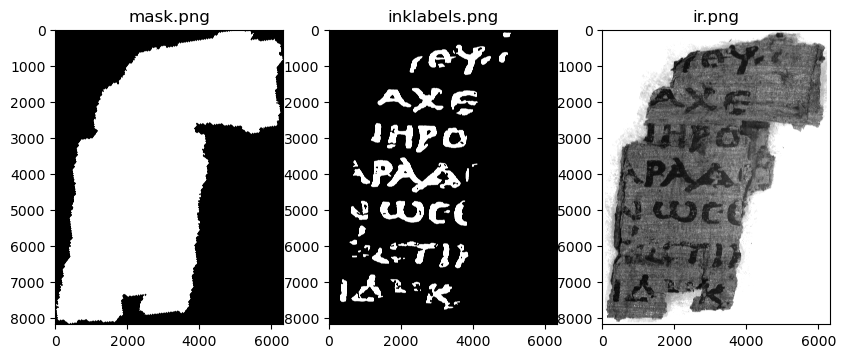

In [3]:
mask = Image.open(path+"train/1/mask.png")
label = Image.open(path+"train/1/inklabels.png")
img = Image.open(path+"train/1/ir.png")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 7))
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label, cmap='gray')
ax3.set_title("ir.png")
ax3.imshow(img, cmap='gray')
plt.show()

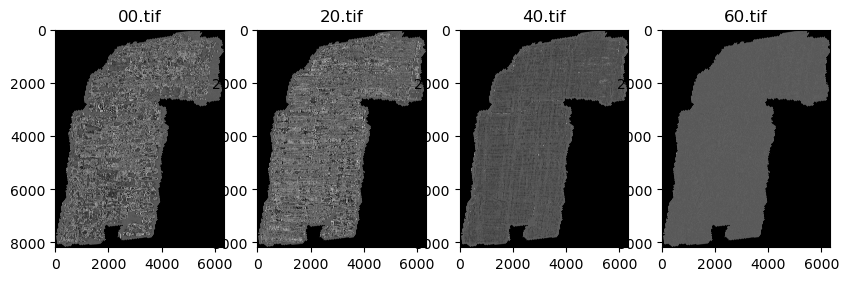

In [4]:
q1 = Image.open(path+"train/1/surface_volume/00.tif")
q2 = Image.open(path+"train/1/surface_volume/20.tif")
q3 = Image.open(path+"train/1/surface_volume/40.tif")
q4 = Image.open(path+"train/1/surface_volume/60.tif")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 7))
ax1.set_title("00.tif")
ax1.imshow(q1, cmap='gray')
ax2.set_title("20.tif")
ax2.imshow(q2, cmap='gray')
ax3.set_title("40.tif")
ax3.imshow(q3, cmap='gray')
ax4.set_title("60.tif")
ax4.imshow(q4, cmap='gray')
plt.show()

<h4>We have :</h4>
1)3 Folders for training and 2 folders for testing<br>
2)Each Folder for training contains: <b>inklabel</b> mask, <b>mask</b> of the scroll, and <b>scroll image</b> as well, apart from that each folder contains <b>scans</b> of <b>65 cuts</b> along <b>Z</b> dimension of the scroll<br>
3)Each Folder for testing contaings: <b>mask</b> of the scroll and <b>scans</b> of <b>65 cuts</b> along <b>Z</b> dimension

<h3>Loading and Preparing Data

<h4>Functions to load and resize images

In [5]:
#resizing keeping original aspect ratio
def resize(img, SHARED_HEIGHT=SHARED_HEIGHT):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

In [6]:
#load mask
def load_mask(split, index, DATA_DIR=path):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return torch.from_numpy(np.array(img))

In [7]:
#load label, target
def load_labels(split, index, DATA_DIR=path):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    return torch.from_numpy(np.array(img)).gt(0).float()

In [8]:
#load stack of slices along Z dimension
def load_volume(split, index, DATA_DIR=path, Z_START=Z_START, Z_DIM=Z_DIM):
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        #65535 is the max value
        z_slice = np.array(img, dtype="float32")/65535.
        z_slices.append(torch.from_numpy(z_slice))
    return torch.stack(z_slices, dim=0)

<h4>Function to get a list of coordinates for the patches and stratification</h4><br> so we can split and have equal amount for train and valid with label and without label

In [9]:
def create_coord_list(img, label_stack, stride=64):
    
    #stratification to split dataset into train and val
    stratification = list()
    #coordinates of the patch
    coord = list()
    for i in range(0, img.shape[0], stride+1):
        for j in range(0, img.shape[1], stride+1):
            img_patch = img[i:i+stride,j:j+stride]
            
            #making sure patch at least on 90% inside mask and right size stride by stride (64x64)
            if (np.count_nonzero(img_patch) >= 0.9 * img_patch.size and img_patch.shape == (stride, stride)):
                #check if label patch is non zero for stratification of dataset in the future
                label_patch = label_stack[i:i+stride,j:j+stride]
                non_zero = label_patch.numpy().sum() > 0
                stratification.append(int(non_zero))
                
                coord.append((i,j))
                
    return coord, stratification

In [10]:
#loading data
masks = [load_mask('train', i) for i in [1,2,3]]
labels = [load_labels('train', i) for i in [1,2,3]]
vols = [load_volume('train', i, Z_DIM=Z_DIM) for i in [1,2,3]]

#stacking data
mask_stack = torch.cat(masks, dim=1)
label_stack = torch.cat(labels, dim=1)
vol_stack = torch.cat(vols, dim=2)

coords, strat = create_coord_list(vol_stack[0].numpy(), label_stack, stride = BUFFER)

train_coords, valid_coords = train_test_split(coords, test_size=0.1, stratify = strat)

print(f"Length of train set: {len(train_coords)}\nLength of validation set: {len(valid_coords)}\nExample: Train{train_coords[0]}\nExample: Valid{valid_coords[0]}")

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3077: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
15it [00:29,  1.95s/it]
15it [02:20,  9.35s/it]
15it [00:20,  1.35s/it]


Length of train set: 4471
Length of validation set: 497
Example: Train(2795, 4810)
Example: Valid(2275, 3315)


<h4>Creating a Dataset class for train and valid</h4> <br>that will accept coordinates for the patch and stack it along Z dimension, since we have more than enough data there is no need to implement augmentation

In [11]:
#DataSet class
class PatchesInkDataset(Dataset):
    def __init__(self, image_stack, label, coords):
        self.image_stack = image_stack
        self.label = label
        self.coords = coords
        #maybe self.transform to try out
    def __len__(self):
        return len(self.coords)
    def __getitem__(self, index):
        y, x = self.coords[index]
        subvolume = self.image_stack[:, y:y+BUFFER, x:x+BUFFER]
        inklabel = self.label[y:y+BUFFER, x:x+BUFFER].unsqueeze(0)
        return subvolume, inklabel

In [12]:
#train loader
train_dataset = PatchesInkDataset(vol_stack, label_stack, train_coords)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#valid loader
val_dataset = PatchesInkDataset(vol_stack, label_stack, valid_coords)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

<h1>Model

In [13]:
#unet model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
    
class StackDecoder(nn.Module):
    def __init__(self,big_channel, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
        )
        
    def forward(self,x, down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  
            x = self.block(x)
            return x
        
        
class Unet(nn.Module):
    def __init__(self, channel = Z_DIM):
        super(Unet,self).__init__()
        
        
        self.down1 = StackEncoder(channel,64,kernel_size=(3,3))  
        self.down2 = StackEncoder(64,128,kernel_size=(3,3))  
        self.down3 = StackEncoder(128,256,kernel_size=(3,3))  
        self.down4 = StackEncoder(256,512,kernel_size=(3,3))  
        self.down5 = StackEncoder(512,1024,kernel_size=(3,3))  
        
        self.center = ConvBlock(1024,1024,kernel_size=(3,3),padding=1) 
        
        self.up5 = StackDecoder(1024,1024,512,kernel_size=(3,3))  
        self.up4 = StackDecoder(512,512,256,kernel_size=(3,3)) 
        self.up3 = StackDecoder(256,256,128,kernel_size=(3,3))
        self.up2 = StackDecoder(128,128,64,kernel_size=(3,3))
        self.up1 = StackDecoder(64,64,64,kernel_size=(3,3))
        self.conv = nn.Conv2d(64,1,kernel_size=(1,1),bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.sig(self.conv(up1))


        return out

<h1>Train and Validate

<h4>Functions to train and validate

In [14]:
#model training function
def train_f(loader, model, optimizer, loss_f):
    
    model.train()
    
    train_loss = []
    
    loop = tqdm(loader)
    for imgs, masks in loop:

        imgs = imgs.to(torch.float).to(DEVICE)
        masks = masks.to(torch.float).to(DEVICE)

        output = model(imgs)
        loss = loss_f(output, masks)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        
        loop.set_description(f"TRAINing Loop...")
        loop.set_postfix(loss= loss.item())

    return sum(train_loss)/len(train_loss)

In [15]:
def dice_modified_score(inputs, targets, smooth = 1.0, beta = 0.5):
    
    assert inputs.size() == targets.size()

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    #modified Dice loss "https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288"
    y_true_count = targets.sum()
    ctp = inputs[targets==1].sum()
    cfp = inputs[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice_loss = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)


    return np.float(dice_loss)

In [16]:
def valid_f(loader, model, loss_f):
    
    model.eval()
    
    val_loss = list()
    
    dice_score = list()
    
    loop = tqdm(loader)
    
    with torch.no_grad():
        for imgs, masks in loop:

            imgs = imgs.to(torch.float).to(DEVICE)
            masks = masks.to(torch.float).to(DEVICE)

            output = model(imgs)
            
            loss = loss_f(output, masks)
            dice = dice_modified_score(output, masks)
            dice_score.append(dice)

            val_loss.append(loss.item())
            
            loop.set_description(f"VALIDating Loop...")
            loop.set_postfix(loss= loss.item(),dice = dice)

        mean_val_loss = sum(val_loss)/len(val_loss)
        mean_dice_score = sum(dice_score)/len(dice_score)
        #scheduler.step(mean_val_loss)
        
        
        return mean_val_loss, mean_dice_score

In [17]:
#DICE loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, inputs, targets):
        
        assert inputs.size() == targets.size()
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)
        
        return dice_loss

In [18]:
#IMPROVED DICE loss
class DiceModif(nn.Module):
    def __init__(self):
        super(DiceModif, self).__init__()
        self.smooth = 1.0
        self.beta = 0.5

    def forward(self, inputs, targets):
        
        assert inputs.size() == targets.size()
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #modified Dice loss "https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288"
        y_true_count = targets.sum()
        ctp = inputs[targets==1].sum()
        cfp = inputs[targets==0].sum()
        beta_squared = self.beta * self.beta

        c_precision = ctp / (ctp + cfp + self.smooth)
        c_recall = ctp / (y_true_count + self.smooth)
        dice_loss = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + self.smooth)
        
        
        return dice_loss

In [19]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, alpha=0.25, gamma=2.0, beta = 0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-5
        self.beta = beta
        
        # BCEWithLogitsLoss doesn't apply sigmoid function
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        assert inputs.size() == targets.size()
        
        bce_loss = self.bce_loss(inputs, targets)

        # Focal loss for hard examples
        focal_weights = (1 - inputs).pow(self.gamma)
        focal_loss = (self.alpha * focal_weights * bce_loss).mean()
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #modified Dice loss "https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288"
        y_true_count = targets.sum()
        ctp = inputs[targets==1].sum()
        cfp = inputs[targets==0].sum()
        beta_squared = self.beta * self.beta

        c_precision = ctp / (ctp + cfp + self.smooth)
        c_recall = ctp / (y_true_count + self.smooth)
        dice_loss = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + self.smooth)

        # Combined loss
        combined_loss = (bce_loss + focal_loss) + self.dice_weight*dice_loss
        
        return combined_loss

In [20]:
model = Unet(channel=Z_DIM).to(DEVICE)

#loss_f = DiceLoss()
#loss_f = DiceModif()
loss_f = CombinedLoss(alpha=0.125, beta = 0.5)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<h4>Training and validating loop

In [21]:
train_overall = list()
valid_overall = list()
dice_overall = list()

best_loss = 100

#early stopping
trigger_count = 0
patience = 10
stop_thresh = 0.001

for epoch in range(100):
    print(f"EPOCH: {epoch}")
    train_loss = train_f(train_loader, model, optimizer, loss_f)
    train_overall.append(train_loss)
    
    valid_loss, dice_score = valid_f(val_loader, model, loss_f)
    valid_overall.append(valid_loss)
    dice_overall.append(dice_score)
    
    #and (best_loss - valid_loss > stop_thresh)
    if (best_loss > valid_loss) and (best_loss - valid_loss > stop_thresh):
        
        best_state = {'epoch':epoch,
                      'state_dict':model.state_dict(),
                      'optimizer':optimizer.state_dict(),
                      #'scheduler': scheduler.state_dict(),
                      'dice_score': valid_loss}
        
        best_loss = valid_loss
        
        trigger_count = 0
    else:
        trigger_count += 1
        
    if trigger_count >= patience:
        torch.save(best_state,f"/kaggle/working/model_ep{epoch}.pth")
        print(f'Early stopping triggered at epoch {epoch}, dice_score={dice_score:.4f}, val_loss={valid_loss:.4f}, best_loss={best_loss:.4f}')
        break

EPOCH: 0


  0%|          | 0/140 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
  0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s, dice=0.0225, loss=0.934]


EPOCH: 1


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.52it/s, dice=0.0112, loss=0.877]


EPOCH: 2


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 19.83it/s, dice=0.0124, loss=0.872]


EPOCH: 3


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.06it/s, dice=0.00141, loss=0.837]


EPOCH: 4


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.37it/s, dice=0.008, loss=0.849]  


EPOCH: 5


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.45it/s, dice=0.0209, loss=0.878]


EPOCH: 6


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.46it/s, dice=0.00381, loss=0.831]


EPOCH: 7


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 19.77it/s, dice=0.00192, loss=0.815]


EPOCH: 8


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.45it/s, dice=0.00422, loss=0.829]


EPOCH: 9


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.54it/s, dice=0.00609, loss=0.828]


EPOCH: 10


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.51it/s, dice=0.00233, loss=0.812]


EPOCH: 11


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.50it/s, dice=0.000591, loss=0.796]


EPOCH: 12


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.35it/s, dice=0.00153, loss=0.795] 


EPOCH: 13


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.52it/s, dice=0.000437, loss=0.796]


EPOCH: 14


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.53it/s, dice=0.0006, loss=0.791]  


EPOCH: 15


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 19.31it/s, dice=0.00141, loss=0.79]  


EPOCH: 16


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.62it/s, dice=0.000381, loss=0.786]


EPOCH: 17


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.48it/s, dice=0.000877, loss=0.791]


EPOCH: 18


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.38it/s, dice=0.000135, loss=0.785]


EPOCH: 19


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.18it/s, dice=0.000369, loss=0.785]


EPOCH: 20


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.45it/s, dice=9.95e-5, loss=0.783] 


EPOCH: 21


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.50it/s, dice=0.00014, loss=0.783] 


EPOCH: 22


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s, dice=0.000164, loss=0.782]


EPOCH: 23


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.46it/s, dice=0.000682, loss=0.783]


EPOCH: 24


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.29it/s, dice=1.44e-5, loss=0.781]


EPOCH: 25


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.38it/s, dice=7.27e-5, loss=0.782] 


EPOCH: 26


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.57it/s, dice=1.17e-5, loss=0.781]


EPOCH: 27


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.56it/s, dice=3e-5, loss=0.781]    


EPOCH: 28


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.22it/s, dice=7.82e-5, loss=0.782] 


EPOCH: 29


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.57it/s, dice=3.84e-5, loss=0.781]


EPOCH: 30


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.43it/s, dice=6.12e-5, loss=0.781] 


EPOCH: 31


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.59it/s, dice=3.9e-5, loss=0.781] 


EPOCH: 32


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.47it/s, dice=1.67e-5, loss=0.781]


EPOCH: 33


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.52it/s, dice=2.78e-5, loss=0.781]


EPOCH: 34


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.54it/s, dice=3.31e-5, loss=0.781] 


EPOCH: 35


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.51it/s, dice=2.78e-5, loss=0.781]


EPOCH: 36


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.54it/s, dice=3.18e-5, loss=0.781]


EPOCH: 37


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.46it/s, dice=5.86e-5, loss=0.781]


EPOCH: 38


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.21it/s, dice=2.36e-5, loss=0.78] 


EPOCH: 39


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.45it/s, dice=7.03e-5, loss=0.781]


EPOCH: 40


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.30it/s, dice=8.35e-5, loss=0.781]


EPOCH: 41


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.42it/s, dice=1.42e-5, loss=0.78]


EPOCH: 42


VALIDating Loop...: 100%|██████████| 16/16 [00:00<00:00, 20.31it/s, dice=5.13e-6, loss=0.78]


Early stopping triggered at epoch 42, dice_score=0.0000, val_loss=0.7800, best_loss=0.7806


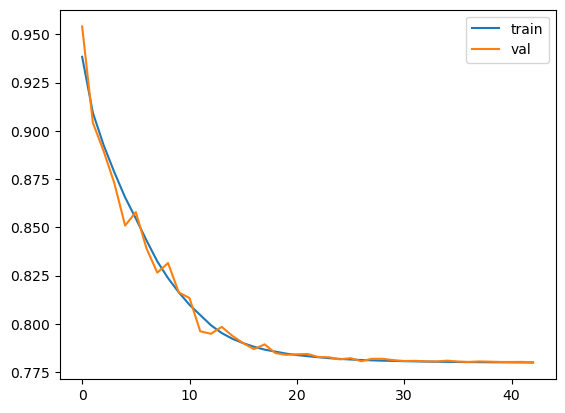

In [22]:
#plotting loss on train and val
#10 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.5
#Z_DIM = 15, Z_START = 15
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

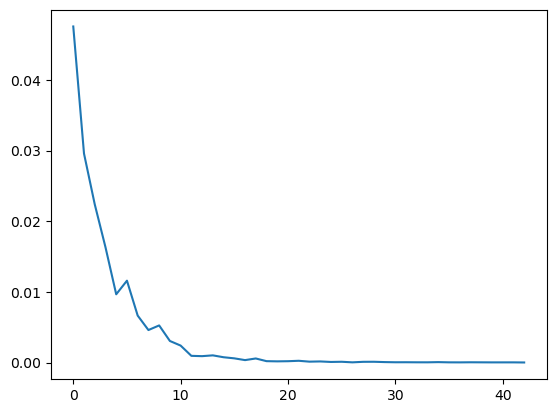

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<h1>NEXT TODO:
    <BR>
1)Just modified DICE loss(DONE)<br>2)Different alpha and beta parameter for combined loss($>$,$<$) (In Process increasing alpha) <br>3)Backbone: EfficientNet + other modern powerful solutions<br>4)preprocessing<br>5)submission file<br>6)Increase lr

In [1]:
model

NameError: name 'model' is not defined

<h1>Experiments:

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;10</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;DICE loss</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

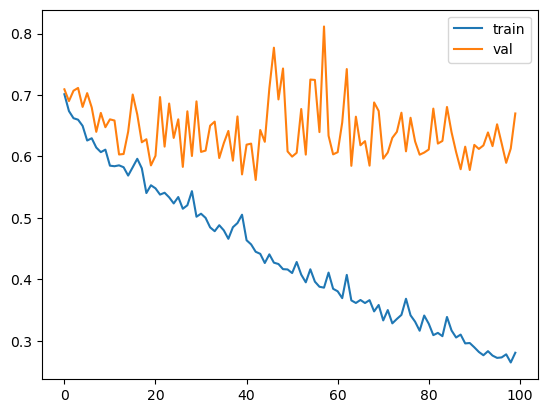

In [22]:
#plotting loss on train and val
#DICE loss only with 10 percent of data for validation
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;DICE loss</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

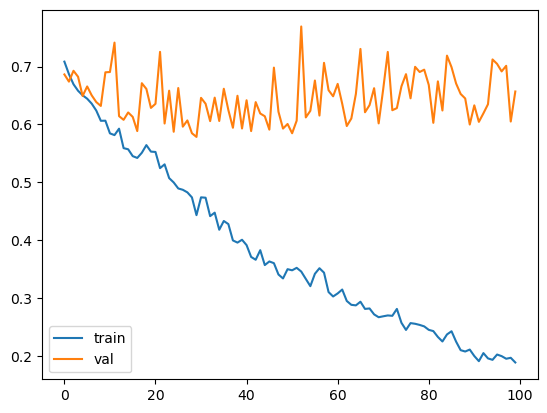

In [23]:
#plotting loss on train and val
#DICE loss only with 30 percent of data for validation
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + Dice</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

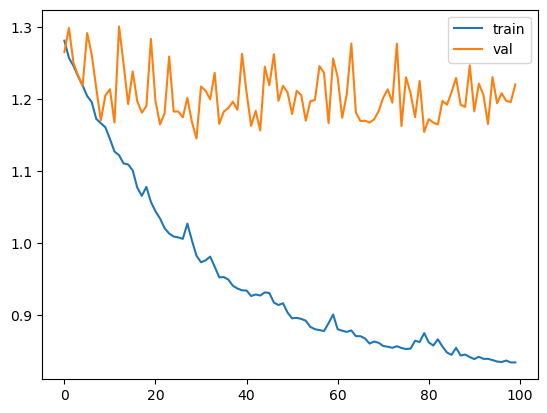

In [23]:
#plotting loss on train and val
#30 percent for validation, combined loss (BCE+Focal + DICE)
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;<i>IMPROVED</i> Dice Loss</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

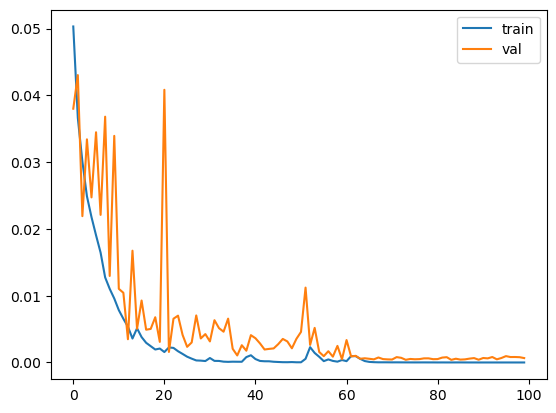

In [23]:
#plotting loss on train and val
#DICE loss IMPROVED only with 30 percent of data for validation
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.25, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

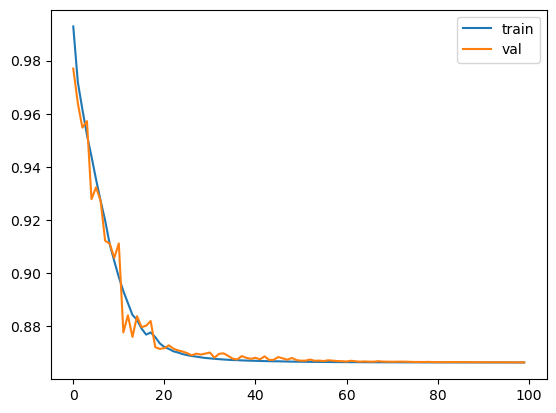

In [23]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.25, beta = 0.5
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

I've lost my graph of Dice score over 100 epochs, but I have a screenshot:
![](https://i.imgur.com/PzldmgC.png)

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.4, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

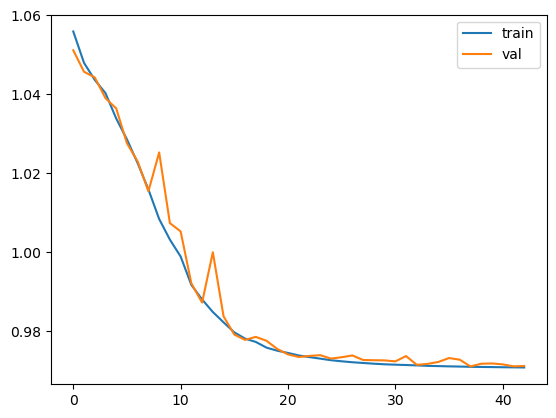

In [23]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.4, beta = 0.5
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

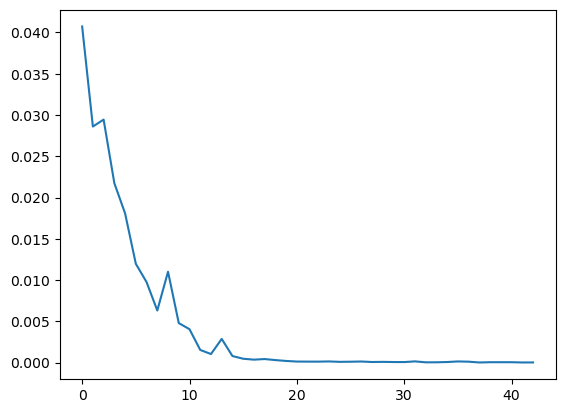

In [22]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

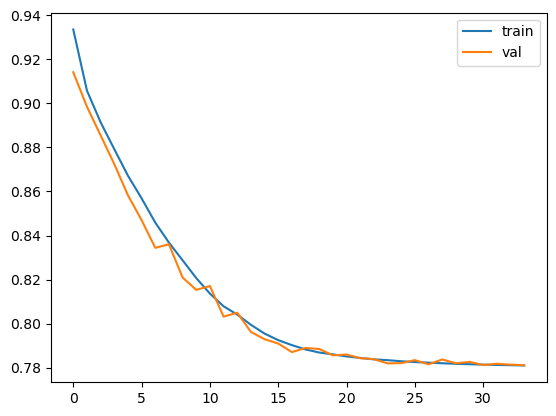

In [22]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.5
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

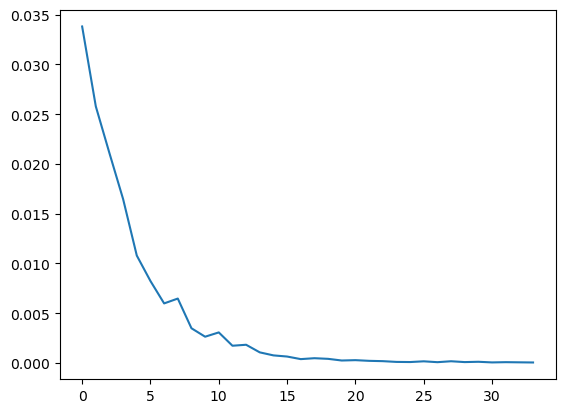

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.07, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

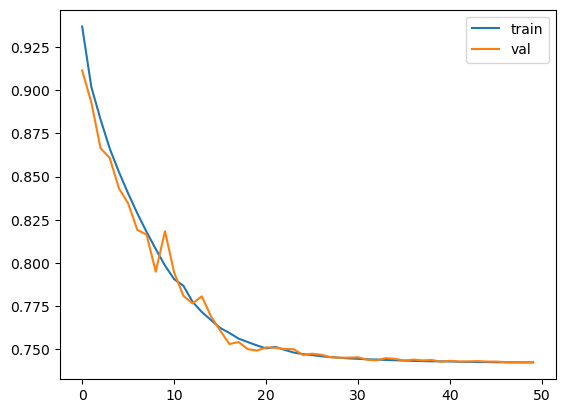

In [22]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.07, beta = 0.5
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

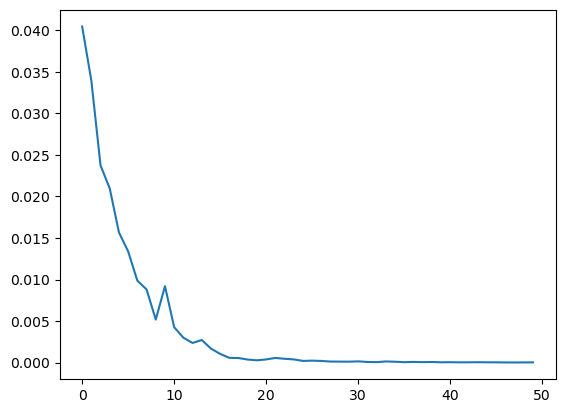

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.8</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

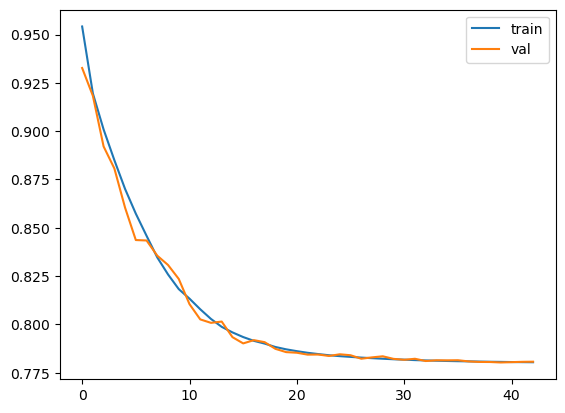

In [22]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.8
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

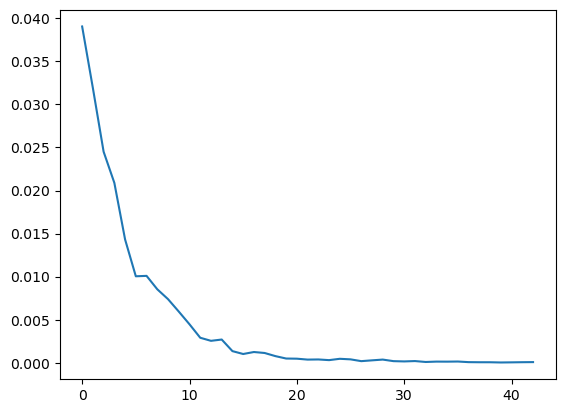

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.2</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

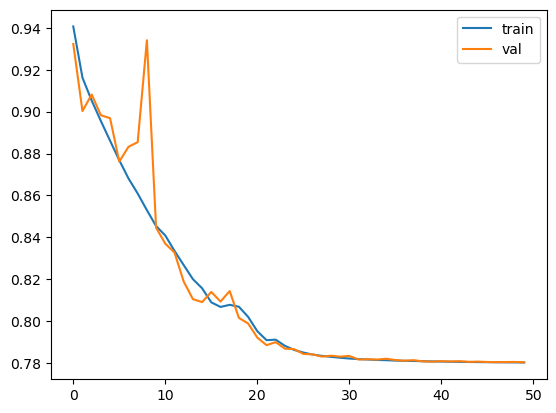

In [22]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.2
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

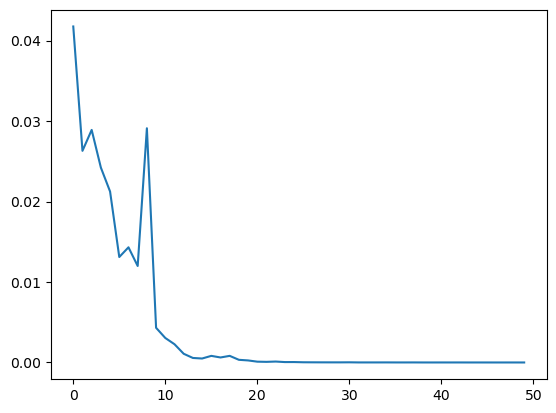

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.65</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

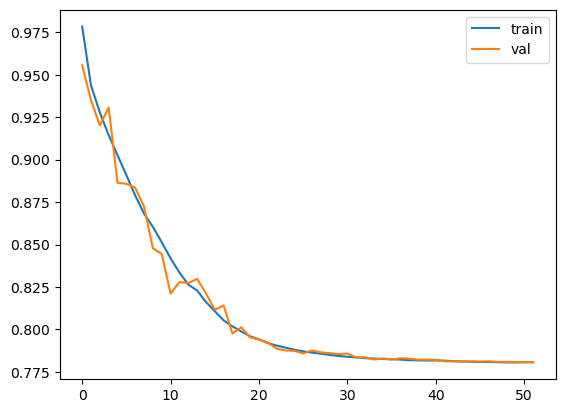

In [22]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.65
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

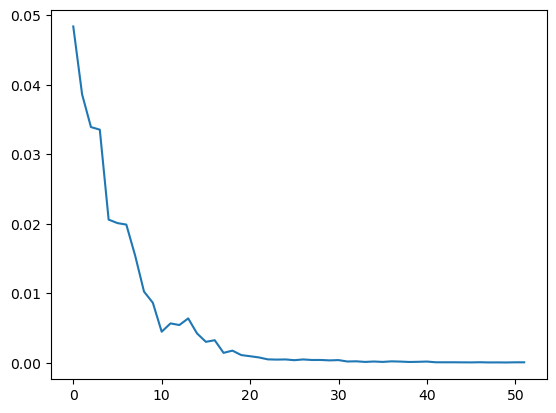

In [23]:
plt.plot(dice_overall,label='dice')
plt.show()

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-3</li>
</ul>

<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = ???</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-5</li>
</ul>

<b>Submission File #1</b>
<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.4</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

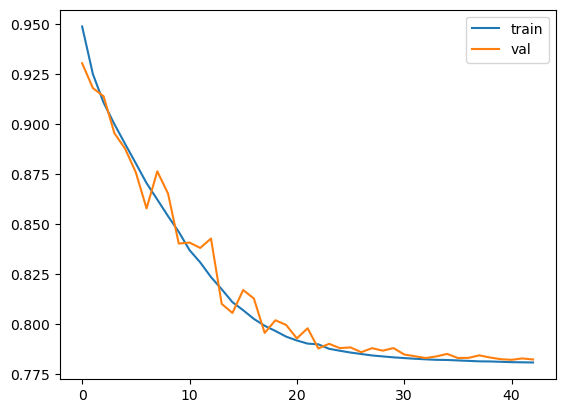

In [23]:
#plotting loss on train and val
#30 percent Combined loss but with improved DICE alpha = 0.125, beta = 0.4
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

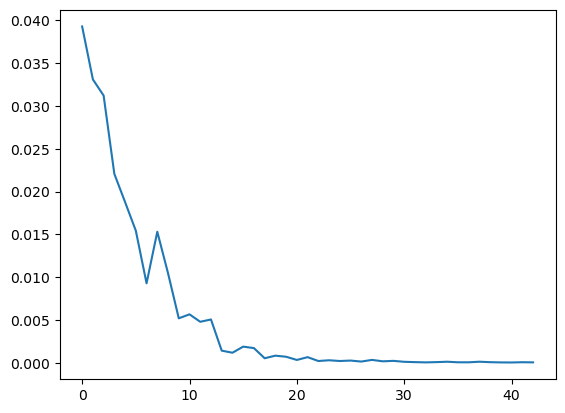

In [24]:
plt.plot(dice_overall,label='dice')
plt.show()

<b>Submission File #1</b>
<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;30</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.4</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
</ul>

<b>Submission File #2</b>
<ul>
    <li><b>Model:</b>&nbsp;&nbsp;&nbsp;Unet</li>
      <li><b>Pretrained:</b>&nbsp;&nbsp;&nbsp;False</li>
      <li><b>Data percentage for valid:</b>&nbsp;&nbsp;&nbsp;10</li>
      <li><b>Loss function:</b>&nbsp;&nbsp;&nbsp;Combined Loss = (BCE+Focal) + <i>IMPROVED</i> Dice</li>
      <li><b>Add info on Loss:</b>&nbsp;&nbsp;&nbsp;alpha = 0.125, beta = 0.5</li>
      <li><b>Learning Rate:</b>&nbsp;&nbsp;&nbsp;1e-4</li>
      <li><b>Add info General:</b>&nbsp;&nbsp;&nbsp;Z_DIM = 15, Z_START = 15</li>
</ul>

## plotting loss on train and val
#Combined Loss, improved DICE
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

At this point I'm happy with the way my training is goin so far. The main issue I had is the validation loss always varies around the same value and doesn't seem to improve at all. Even Combined loss by itself didn't really helped much. Since I thought that there might be a chance that on train it improves really good at easy cases but can't really handle more complicated cases. But turned out not to be the case and the issue was underlying in Dice loss, which needed a few adjestment to make it work properly

In [24]:
path

'/kaggle/input/vesuvius-challenge-ink-detection/'

<h1>INFERENCE!

In [ ]:
model_path = ""

#loading model
model = Unet()
model.load_state_dict(torch.load(model_path))
model.eval()

In [25]:
def is_in_masked_zone(location, mask):
    return mask[location[0].long(), location[1].long()]

def get_subvolume(self, batch_loc, volume, labels):
    # batch_loc : [batch_size, 2]
    subvolume = list()
    label = list()
    for l in batch_loc:
        x = l[0]
        y = l[1]
        sv = volume[:, x - BUFFER:x + BUFFER, y - BUFFER:y + BUFFER]
        sv = sv / 65535.
        subvolume.append(sv)
        if labels is not None:
            lb = labels[x - BUFFER:x + BUFFER, y - BUFFER:y + BUFFER]
            lb = lb.unsqueeze(0)
            label.append(lb)
    # [batch, Z_DIM, BUFFER, BUFFER]
    subvolume = torch.stack(subvolume)
    # [batch, 1, BUFFER, BUFFER]
    if labels is not None:
        label = torch.stack(label)
    return subvolume, label

def compute_predictions_map(split, index, model):
    print(f"======> Load data for {split}/{index}")
    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)
    print(f"======> Volume shape: {test_volume.shape}")
    test_locations = list()
    stride = BUFFER // 2

    for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[2] - BUFFER, stride):
            if is_in_masked_zone([torch.tensor(x),torch.tensor(y)], test_mask):
                test_locations.append((x, y))
    print(f"======> {len(test_locations)} test locations (after filtering by mask)")

    predictions_map = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    predictions_map_counts = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    print(f"======> Compute predictions")
    with torch.no_grad():
        bar = tqdm(test_locations)
        for loc in bar:
            subvolume, label = get_subvolume([loc], test_volume, None)
            pred = model(subvolume.to(DEVICE))
            # print(loc, (pred > 0.5).sum())
            # Here a single location may be with multiple result
            predictions_map[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += pred.cpu()
            predictions_map_counts[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += 1

    # print(predictions_map_b[:,:, 2500, 1000])
    # print(predictions_map_counts[:,:, 2500, 1000])
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [27]:
import os

In [ ]:
TEST_DIRS = sorted(os.listdir("../input/vesuvius-challenge-ink-detection/test"))

predictions_maps = list()
for index in TEST_DIRS:
    predictions_map = compute_predictions_map(split="test", index=index, model= model)
    predictions_maps.append(predictions_map)

original_size_imgs = list()
for TEST_DIR in TEST_DIRS:
    original_size_img = Image.open(path + f"/test/{TEST_DIR}/mask.png").size
    original_size_imgs.append(original_size_img)   

rescaled_predictions_maps = list()
for prediction_map, original_size_img in zip(predictions_maps, original_size_imgs):
    prediction_map = resize_ski(prediction_map.squeeze(), original_size_img).squeeze()
    rescaled_predictions_maps.append(prediction_map)

rles = list()
for rescaled_predictions_map in rescaled_predictions_maps:
    rle_value = rle(rescaled_predictions_map, threshold=THRESHOLD)
    rles.append(rle_value)
    
submission = pd.DataFrame({'Id': TEST_DIRS,
                           'Predicted': rles})

submission.to_csv('../working/submission.csv', index=False)

======> Load data for test/a


20it [00:17,  1.13it/s]


This was a result of training Unet with very small validation set of 470 samples. Before assuming model is overfitting I want to increase validation set from 9:1 to 7:3 train to valid respectfuly 

In [ ]:
model = Unet(channel=Z_DIM).to(DEVICE)

loss_f = DiceLoss()

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_overall = list()
valid_overall = list()

best_dice = 2

for epoch in range(250):
    
    train_loss = train_f(train_loader, model, optimizer, loss_f)
    train_overall.append(train_loss)
    print(f"Train DICE Loss: {train_loss}, Epoch:{epoch}")
    
    valid_loss = valid_f(val_loader, model, loss_f)
    valid_overall.append(valid_loss)
    
    if best_dice > valid_loss:
        
        best_state = {'epoch':epoch,
                      'state_dict':model.state_dict(),
                      'optimizer':optimizer.state_dict(),
                      #'scheduler': scheduler.state_dict(),
                      'dice_score': valid_loss}
        
        best_dice = valid_loss

In [ ]:
#plotting loss on train and val
plt.plot(train_overall,label='train')
plt.plot(valid_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
torch.save(best_state, f"/kaggle/working/more_epochs.pth.tar")

In [ ]:
t1.shape

In [ ]:
t2.shape

<h3>Model

First of all, I want to train just Unet architecture without any backbone and have this results as baseline

In [ ]:
#unet model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
    
class StackDecoder(nn.Module):
    def __init__(self,big_channel, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
        )
        
    def forward(self,x, down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  
            x = self.block(x)
            return x
        
        
class Unet(nn.Module):
    def __init__(self, channel = Z_DIM):
        super(Unet,self).__init__()
        
        
        self.down1 = StackEncoder(channel,64,kernel_size=(3,3))  
        self.down2 = StackEncoder(64,128,kernel_size=(3,3))  
        self.down3 = StackEncoder(128,256,kernel_size=(3,3))  
        self.down4 = StackEncoder(256,512,kernel_size=(3,3))  
        self.down5 = StackEncoder(512,1024,kernel_size=(3,3))  
        
        self.center = ConvBlock(1024,1024,kernel_size=(3,3),padding=1) 
        
        self.up5 = StackDecoder(1024,1024,512,kernel_size=(3,3))  
        self.up4 = StackDecoder(512,512,256,kernel_size=(3,3)) 
        self.up3 = StackDecoder(256,256,128,kernel_size=(3,3))
        self.up2 = StackDecoder(128,128,64,kernel_size=(3,3))
        self.up1 = StackDecoder(64,64,64,kernel_size=(3,3))
        self.conv = nn.Conv2d(64,1,kernel_size=(1,1),bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.sig(self.conv(up1))


        return out

In [ ]:
#DICE loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, inputs, targets):
        
        assert inputs.size() == targets.size()
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)
        
        return dice_loss

In [ ]:
#model training function
def train_f(loader, model, optimizer, loss_f):
    
    model.train()
    
    train_loss = []
    
    loop = tqdm(loader)
    for imgs, masks in loop:

        imgs = imgs.to(torch.float).to(DEVICE)
        masks = masks.to(torch.float).to(DEVICE)

        output = model(imgs)
        loss = loss_f(output, masks)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        
        loop.set_description(f"Training Loop...")
        loop.set_postfix(loss= loss.item())

    return sum(train_loss)/len(train_loss)

In [ ]:
def valid_f(loader, model, loss_f):
    
    #early stopping init
    last_loss = 2
    patience = 5
    trigger_times = 0
    
    model.eval()
    
    val_loss = []
    best_dice = 1
    
    loop = tqdm(loader)
    
    with torch.no_grad():
        for imgs, masks in loop:

            imgs = imgs.to(torch.float).to(DEVICE)
            masks = masks.to(torch.float).to(DEVICE)

            output = model(imgs)
            
            loss = loss_f(output, masks)

            val_loss.append(loss.item())
            
            loop.set_description(f"Validating Loop...")
            loop.set_postfix(loss= loss.item())

        mean_val_loss = sum(val_loss)/len(val_loss)
        #scheduler.step(mean_val_loss)
        

        #early stopping
        if mean_val_loss > last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                sys.exit()
        else:
            trigger_times = 0
        last_loss = mean_val_loss
        
        #saving best states based on validation loss
        if best_dice > mean_val_loss:

            best_state = {'epoch':epoch,
                          'state_dict':model.state_dict(),
                          'optimizer':optimizer.state_dict(),
                          #'scheduler': scheduler.state_dict(),
                          'dice_score': mean_val_loss}
        
        return mean_val_loss

In [ ]:
model = Unet(channel=Z_DIM).to(DEVICE)

loss_f = DiceLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, min_lr = 1e-6, verbose = True)

In [ ]:
train_overall = list()
valid_overall = list()

for epoch in range(20):
    
    train_loss = train_f(train_loader, model, optimizer, loss_f)
    train_overall.append(train_loss)
    print(f"Train DICE Loss: {train_loss}, Epoch:{epoch}")
    
    valid_loss = valid_f(val_loader, model, loss_f)
    valid_overall.append(valid_loss)
    print(f"Val DICE Loss: {valid_loss}")

In [ ]:
plt.plot(train_overall,label='train')
plt.plot(val_overall,label='val')
plt.legend(['train', 'val'])
plt.show()
torch.save(best_state,f"/kaggle/working/plain_unet.pth")

In [ ]:
torch.save(best_state,f"/kaggle/working/plain_unet.pth")

Ran a test for 2 epochs to just see if everything works and ready to train so I can activate GPU and run it for a bit, without loosing any time more than necessary

<h1>TODO:</h1>
<b>
1. Simple model and try to train for 2 epochs<br>
2. Build train and val functions <br>
3. Figure out RLE after satisfied with results<br>

<H3>DITCHED

In [ ]:
'''
masks = [load_mask('train', i) for i in [1,2,3]]
labels = [load_labels('train', i) for i in [1,2,3]]
vols = [load_volume('train', i, Z_DIM=2) for i in [1,2,3]]
mask_stack = torch.cat(masks, dim=1)
label_stack = torch.cat(labels, dim=1)
vol_stack = torch.cat(vols, dim=2)

#visualize validation area to holdout
rect = (1000, 2500, 5000, 400)
fig, ax = plt.subplots()
ax.imshow(label_stack.numpy(), cmap='gray')
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

#freeing up the memory
del vols
del masks
del labels
del patch

fig.clear()
plt.close(fig)'''


#plt.imshow(vol_stack[0].numpy(),cmap='gray')

'''# Random choice of patches for training
def sample_random_location(shape, BUFFER=BUFFER):
    #generating random location and making it 2*BUFFER+1 away from the edge 
    random_train_x = (shape[0] - 2*BUFFER - 1)*torch.rand(1)+BUFFER
    random_train_y = (shape[1] - 2*BUFFER - 1)*torch.rand(1)+BUFFER
    random_train_location = torch.stack([random_train_x, random_train_y])
    return random_train_location

#check if mask has value in location
def is_in_masked_zone(location, mask):
    #convert to int and check if value exists in this location
    return mask[location[0].long(), location[1].long()]

#check if location in validation zone
def is_in_val_zone(location, val_location, val_zone_size, BUFFER=BUFFER):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

class RandomPatchLocDataset(Dataset):
    def __init__(self, mask, val_location, val_zone_size):
        self.mask = mask
        self.val_location = val_location
        self.val_zone_size = val_zone_size
        self.sample_random_location_train = lambda x: sample_random_location(mask.shape)
        self.is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

    def is_proper_train_location(self, location):
        return not is_in_val_zone(location, self.val_location, self.val_zone_size) and self.is_in_mask_train(location)

    def __len__(self):
        return 1280

    def __getitem__(self, index):
        # Generate a random patch
        # Ignore the index
        loc = self.sample_random_location_train(0)
        while not self.is_proper_train_location(loc):
            loc = self.sample_random_location_train(0)
        return loc.int().squeeze(1)

val_xy = (1000, 2500)
val_size = (5000, 400)

#train
loc_datast = RandomPatchLocDataset(mask_stack, val_location=val_xy, val_zone_size=val_size)
loc_loader = DataLoader(loc_datast, batch_size=32)
# Val
val_loc = []
for x in range(val_xy[0], val_xy[0] + val_size[0], BUFFER):
    for y in range(val_xy[1], val_xy[1] + val_size[1], BUFFER):
        if is_in_masked_zone([torch.tensor(y),torch.tensor(x)], mask_stack):
            val_loc.append([[y, x]])
print(f"======> Num Patches Val: {len(val_loc)}")

    def get_subvolume(self, batch_loc, volume, labels):
        # batch_loc : [batch_size, 2]
        subvolume = []
        label = []
        for l in batch_loc:
            x = l[0]
            y = l[1]
            sv = volume[:, x - self.opt.BUFFER:x + self.opt.BUFFER, y - self.opt.BUFFER:y + self.opt.BUFFER]
            sv = sv / 65535.
            subvolume.append(sv)
            if labels is not None:
                lb = labels[x - self.opt.BUFFER:x + self.opt.BUFFER, y - self.opt.BUFFER:y + self.opt.BUFFER]
                lb = lb.unsqueeze(0)
                label.append(lb)
        # [batch, Z_DIM, BUFFER, BUFFER]
        subvolume = torch.stack(subvolume)
        # [batch, 1, BUFFER, BUFFER]
        if labels is not None:
            label = torch.stack(label)
        return subvolume, label'''

As a first time participant in competition I found it quite hard to get start on the project and get your head around all of the information. So I started digging into all data I can find and when I was ready I started trying to figure out how can I go about this type of problem I've never seen. So I started looking how people got their data ready for the problem and if my theory was right. So I found out that I can understand their code, I mean I understood what its suppose to do but what exactly goes into code left me question their reasoning for why is it this way. It left me thinking for days how can I get my data the right way. Which left a lot of question but I rather try to do it my way and not copy code for the sake of getting my data ready. I WANT TO GET KNOWLEDGE FIRST OF ALL. Which is why I'm ditching above code for my own variation but I think its way more intuitive and feels at least to me like it has more meaning behind it(I really didn't like sample random location function which to me seemed like a random thing to do there with random amount of iterations on random sample)